In [6]:
# LOAD DATASET
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
from modules.ML_tools import MissingValuesImputer, zero_one_loss, precision, recall, F1_score
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

# fetch dataset 
secondary_mushroom = fetch_ucirepo(id=848) 
  
# data (as pandas dataframes) 
X = secondary_mushroom.data.features 
y = secondary_mushroom.data.targets 
y.loc[:, 'class'] = y['class'].map({'e': True, 'p': False})

#X = X.drop(columns=['does-bruise-or-bleed'])

random_state = 24

# Split train e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=random_state)

print("Dataset size      |", X.shape[0])
print("Training set size |", X_train.shape[0])
print("Test set size     |", X_test.shape[0])

e1 = round(y['class'].sum() / y.shape[0], 2)
e2 = round(y_train['class'].sum() / y_train.shape[0], 2)
e3 = round(y_test['class'].sum() / y_test.shape[0], 2)
print(f"Dataset edible ratio: e:{e1}, p:{1-e1}")
print(f"Training set edible ratio: e:{e2}, p:{1-e2}")
print(f"Test set edible ratio: e:{e3}, p:{1-e3}")

Dataset size      | 61069
Training set size | 42748
Test set size     | 18321
Dataset edible ratio: e:0.45, p:0.55
Training set edible ratio: e:0.45, p:0.55
Test set edible ratio: e:0.44, p:0.56


Tree predictor

In [2]:
from modules.tree import TreePredictor

# Preprocessing
imputer = MissingValuesImputer()
X_train_i = imputer.fit_transform(X_train)
X_test_i = imputer.transform(X_test)

#Training tree predictor
tp = TreePredictor(max_depth = 28, min_samples_leaf = 1, splitting_criterion="scaled_entropy")
tp.train(X_train_i, y_train, num_thresholds=50)
tp_training_error = tp.training_error
print(tp.tree_info)

{'num_leaves': 180, 'max_depth': 22}


In [3]:
print(tp.root.right_child.left_child.info)

{'num_samples': 871, 'True_samples': 0, 'False_samples': np.int64(871), 'label': False}


training error  | 0.0 %
test_error      | 0.136 %
train accuracy  | 100.0 %
test accuracy   | 99.864 %
test precision  | 99.79 %
test recall     | 99.901 %
f1 score        | 99.845 %
Confusion matrix:


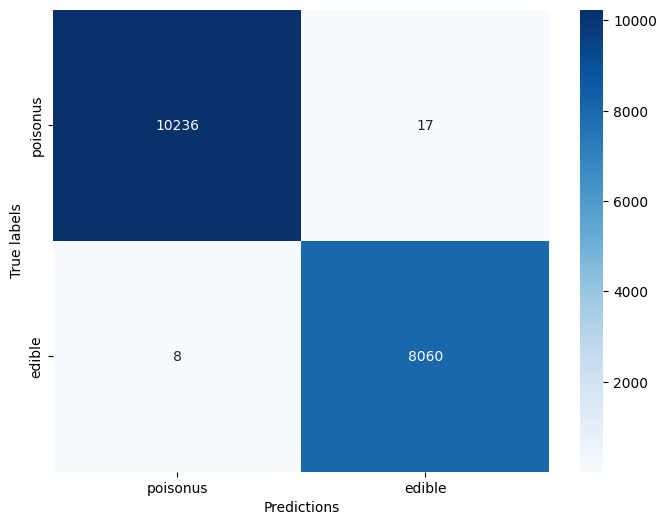

In [4]:
#Test tree predictor
predictions = tp.predict(X_test_i)

test_error = zero_one_loss(y_test['class'].tolist(), predictions)
p = precision(y_test['class'].tolist(), predictions)
r = recall(y_test['class'].tolist(), predictions)
f1 = F1_score(y_test['class'].tolist(), predictions)

print("training error  |", round(tp_training_error * 100, 3), "%")
print("test_error      |", round(test_error *100,3), "%")

print("train accuracy  |", round((1-tp_training_error) * 100, 3), "%")
print("test accuracy   |", round((1-test_error)*100,3), "%")

print("test precision  |", round(p*100,3), "%")
print("test recall     |", round(r*100,3), "%")
print("f1 score        |", round(f1*100,3), "%")

cm = confusion_matrix(y_test['class'].tolist(), predictions)
print("Confusion matrix:")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['poisonus', 'edible'], 
            yticklabels=['poisonus', 'edible'])
plt.xlabel('Predictions')
plt.ylabel('True labels')
plt.show()

Random forest

In [7]:
from modules.tree import RandomForest

# Preprocessing
imputer = MissingValuesImputer()
X_train_i = imputer.fit_transform(X_train)
X_test_i = imputer.transform(X_test)

# Train random forest
seed = 1
num_trees = 30
num_candidate_attributes = 5

rf = RandomForest(max_depth=None, min_samples_leaf=1, splitting_criterion="scaled_entropy", compute_oob_score=True, num_candidate_attributes=num_candidate_attributes, random_state=seed)
rf.train(X_train_i, y_train, num_thresholds=50, num_trees=num_trees, max_workers=4)

rf_training_error = rf.mean_training_error
rf_oob_score = rf.oob_error

training error    | 0.293 %
test_error        | 0.005 %
train accuracy    | 99.707 %
oob score         | 100.0 %
test accuracy     | 99.995 %
test precision    | 99.988 %
test recall       | 100.0 %
f1 score          | 99.994 %
Confusion matrix:


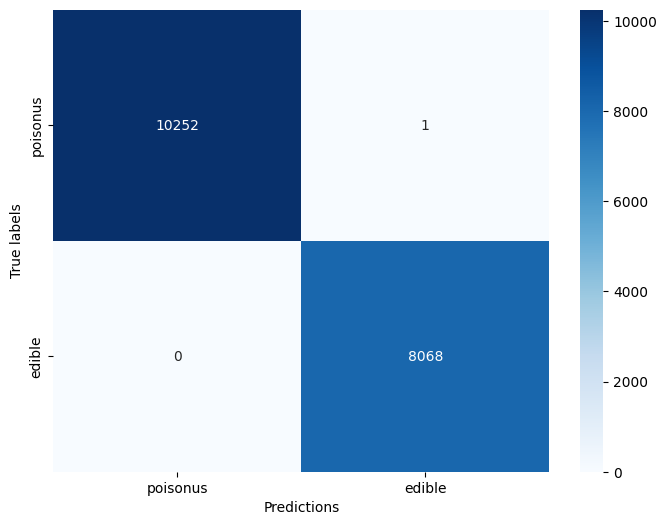

In [8]:
#Test Random forest
predictions = rf.predict(X_test_i)

test_error = zero_one_loss(y_test['class'].tolist(), predictions)
p = precision(y_test['class'].tolist(), predictions)
r = recall(y_test['class'].tolist(), predictions)
f1 = F1_score(y_test['class'].tolist(), predictions)

print("training error    |", round(rf_training_error * 100, 3), "%")
print("test_error        |", round(test_error *100,3), "%")

print("train accuracy    |", round((1-rf_training_error) * 100, 3), "%")
if rf_oob_score is not None:
    print("oob score         |", round((1-rf_oob_score) * 100, 3), "%")
print("test accuracy     |", round((1-test_error)*100,3), "%")

print("test precision    |", round(p*100,3), "%")
print("test recall       |", round(r*100,3), "%")
print("f1 score          |", round(f1*100,3), "%")

cm = confusion_matrix(y_test['class'].tolist(), predictions)
print("Confusion matrix:")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['poisonus', 'edible'], 
            yticklabels=['poisonus', 'edible'])
plt.xlabel('Predictions')
plt.ylabel('True labels')
plt.show()